In [2]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1 Baseline

Считываем данные, строим baseline модель и рассматриваем разные метрики и графики для задачи классификации.

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

plt.style.use('ggplot')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


### 1.1 Данные

In [5]:
data_train = pd.read_csv('/content/drive/MyDrive/data_train_with_features.csv')
data_train.shape

(831653, 260)

In [6]:
data_train.head()

,Unnamed: 0,id,vas_id,buy_time,target,id_other,buy_time_other,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,0,2,2.0,1545598800,0.0,2,1545598800,-96.799971,229.530888,-110.740786,305.723202,-116.158246,284.61821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,...,-40151.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-5.726695e+08,-58.544078,1.103360e+09,-1.204418e+08,0.899332,-1.465191,-33.302382,730.871014,80.227508,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,249.30898,0.631719,-247.110707,-108.409742,606.562669,5.382022,-17.295406,2300.626154,1492.229208,-21.996269,-35.630448,368.252276,11.167111,7.305572,-12.175933,-0.45614,0.0
1,1,4,1.0,1533502800,0.0,4,1538341200,-96.799971,-323.429112,-110.740786,-376.036798,-116.158246,-397.14179,-16.08618,19.673903,-6.78366,54.743462,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,-0.799862,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,...,-42051.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-5.726695e+08,-58.544078,-4.405604e+08,-1.204418e+08,14.565998,-1.465191,-33.302382,737.871014,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-332.69102,-3.368281,-247.110707,-108.409742,27.562669,-106.617978,257.704594,4806.626154,4140.229208,-25.996269,-37.630448,-35.747724,-20.832889,-0.694428,-7.175933,-0.45614,0.0
2,2,15,1.0,1534107600,0.0,15,1531688400,260.810029,186.710888,249.409214,140.873202,243.991754,119.76821,341.52382,317.953903,-6.78366,-30.006538,-2.736081,-2.317526,353.361088,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-11.400815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,...,-40391.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,9.595373e+08,-56.854078,1.067232e+09,-1.204418e+08,2.565998,0.534809,-33.302382,996.871014,-37.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,2644.30898,-4.368281,-247.110707,-108.409742,3007.562669,-68.617978,-16.295406,-381.373846,-613.770792,-24.996269,-31.630448,-212.747724,108.167111,-0.694428,107.824067,13.54386,1.0
3,3,16,2.0,1540760400,0.0,16,1548018000,152.050029,257.220888,195.609214,267.113202,190.191754,246.00821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,182.660873,171.33189,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,43.559185,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,...,-40521.166127,-9239.707081,-2.10805,-0.000083,1.377104,-0.00004,1.379228,-0.012257,-0.107878,9.758669e+08,-22.994078,1.105593e+09,-1.204418e+08,-6.913168,-1.465191,-33.302382,496.871014,-38.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-448.69102,-5.368281,-246.110707,-108.409742,-85.437331,-41.617978,-17.295406,3185.626154,-613.770792,-21.996269,-37.630448,-139.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
4,4,29,1.0,1533502800,0.0,29,1532898000,-52.309971,-230.219112,-36.590786,-248.926798,-42.008246,-270.03179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-21.699127,-33.02811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,15.719185,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,...,-41661.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.0000

In [7]:
data_train = data_train.set_index('Unnamed: 0')

In [8]:
data_train.head()

,id,vas_id,buy_time,target,id_other,buy_time_other,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2,2.0,1545598800,0.0,2,1545598800,-96.799971,229.530888,-110.740786,305.723202,-116.158246,284.61821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-40151.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-5.726695e+08,-58.544078,1.103360e+09,-1.204418e+08,0.899332,-1.465191,-33.302382,730.871014,80.227508,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,249.30898,0.631719,-247.110707,-108.409742,606.562669,5.382022,-17.295406,2300.626154,1492.229208,-21.996269,-35.630448,368.252276,11.167111,7.305572,-12.175933,-0.45614,0.0
1,4,1.0,1533502800,0.0,4,1538341200,-96.799971,-323.429112,-110.740786,-376.036798,-116.158246,-397.14179,-16.08618,19.673903,-6.78366,54.743462,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,-0.799862,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-42051.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-5.726695e+08,-58.544078,-4.405604e+08,-1.204418e+08,14.565998,-1.465191,-33.302382,737.871014,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-332.69102,-3.368281,-247.110707,-108.409742,27.562669,-106.617978,257.704594,4806.626154,4140.229208,-25.996269,-37.630448,-35.747724,-20.832889,-0.694428,-7.175933,-0.45614,0.0
2,15,1.0,1534107600,0.0,15,1531688400,260.810029,186.710888,249.409214,140.873202,243.991754,119.76821,341.52382,317.953903,-6.78366,-30.006538,-2.736081,-2.317526,353.361088,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-11.400815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-40391.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,9.595373e+08,-56.854078,1.067232e+09,-1.204418e+08,2.565998,0.534809,-33.302382,996.871014,-37.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,2644.30898,-4.368281,-247.110707,-108.409742,3007.562669,-68.617978,-16.295406,-381.373846,-613.770792,-24.996269,-31.630448,-212.747724,108.167111,-0.694428,107.824067,13.54386,1.0
3,16,2.0,1540760400,0.0,16,1548018000,152.050029,257.220888,195.609214,267.113202,190.191754,246.00821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,182.660873,171.33189,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,43.559185,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,...,-40521.166127,-9239.707081,-2.10805,-0.000083,1.377104,-0.00004,1.379228,-0.012257,-0.107878,9.758669e+08,-22.994078,1.105593e+09,-1.204418e+08,-6.913168,-1.465191,-33.302382,496.871014,-38.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-448.69102,-5.368281,-246.110707,-108.409742,-85.437331,-41.617978,-17.295406,3185.626154,-613.770792,-21.996269,-37.630448,-139.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
4,29,1.0,1533502800,0.0,29,1532898000,-52.309971,-230.219112,-36.590786,-248.926798,-42.008246,-270.03179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-21.699127,-33.02811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,15.719185,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.3518

In [9]:
data_test = pd.read_csv('/content/drive/MyDrive/data_test_with_features.csv')
data_test.shape

(71231, 259)

In [10]:
data_test.head()

,Unnamed: 0,id,vas_id,buy_time,id_other,buy_time_other,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,0,55,2.0,1547413200,54,1537131600,4.320029,-157.679112,-9.620786,-201.816798,-15.038246,144.03821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-16.769127,5.80189,-0.000725,-0.016435,-0.107041,-5.41746,14.621479,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,15.717791,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-42051.166127,-9236.707081,47.89195,-0.000083,2.377104,-0.00004,2.379228,-0.012257,-0.107878,9.649805e+08,-51.484078,6.531241e+08,1.380634e+09,-11.600668,-1.465191,-33.302382,-266.128986,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-106.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
1,1,64,4.0,1548018000,63,1532293200,504.740029,1330.840888,519.619214,1388.833202,514.201754,1367.72821,532.21382,1201.013903,-6.78366,208.924692,-2.736081,493.442474,48.291088,-66.189127,-35.98811,-0.000725,-0.016435,-0.107041,-5.41746,8.531479,14.879185,480.775836,-0.094251,-0.001733,-0.009327,9.627791,0.200138,-0.00909,0.648138,1.785634,0.788392,-0.001884,-0.000023,-0.00003,...,-42051.166127,-9239.707081,-2.10805,-0.000083,3.377104,-0.00004,3.379228,-0.012257,-0.107878,-5.726695e+08,-58.544078,-4.405604e+08,-1.204418e+08,-13.426249,-1.465191,-33.302382,-170.128986,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-873.69102,-5.368281,-247.110707,-108.409742,-509.437331,7385.382022,-17.295406,-943.373846,-613.770792,-25.996269,-26.630448,106.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,2,151,2.0,1547413200,145,1547413200,-20.989971,-147.029112,-34.930786,-199.636798,-40.348246,-220.74179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,9.620873,-1.70811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-42051.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,9.752621e+08,-47.714078,-4.405604e+08,1.357031e+09,-7.225668,-1.465191,-33.302382,407.871014,-34.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,2771.30898,-1.368281,1042.889293,-108.409742,1841.562669,-94.617978,-17.295406,-940.373846,-605.770792,-13.996269,-37.630448,-158.747724,109.167111,-0.694428,-12.175933,-0.45614,0.0
3,3,274,2.0,1547413200,265,1537736400,-52.279971,-26.709112,-66.220786,-79.316798,-71.638246,-100.42179,-16.08618,138.313903,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-21.669127,-32.99811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.655853e+08,-52.184078,9.697523e+08,-1.204418e+08,-4.350668,-1.465191,-33.302382,-141.128986,-37.772492,-0.364694,-0.133771,-0.209468,-33.356505,-109.884564,-78.69102,-1.368281,122.889293,-108.409742,-88.437331,-106.617978,-17.295406,-879.373846,-554.770792,-21.996269,-37.630448,16.252276,-17.832889,-0.694428,-4.175933,-0.45614,1.0
4,4,274,4.0,1548018000,265,1537736400,-52.279971,-26.709112,-66.220786,-79.316798,-71.638246,-100.42179,-16.08618,138.313903,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-21.669127,-32.99811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-42051.166127,-9239.707081,-

In [11]:
data_test = data_test.set_index('Unnamed: 0')

In [12]:
# Разделим признаки и целевую переменную
data_prelim = data_train.copy()

X = data_prelim.drop('target', axis=1)
y = data_prelim['target']

In [13]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 0%


**У признаков нет пропущенных значений**

### 1.2 Смотрим на train и test

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

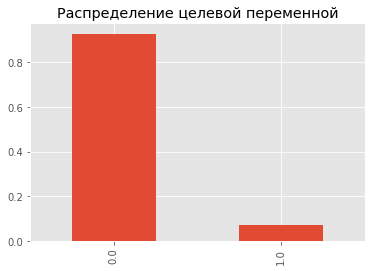

In [14]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [15]:
from sklearn.model_selection import train_test_split

# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 888

train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.927652
1.0    0.072348
Name: target, dtype: float64

Test
0.0    0.927566
1.0    0.072434
Name: target, dtype: float64


### 1.3 Pipeline для baseline модели

In [16]:
from sklearn.pipeline import Pipeline

Для построения baseline модели будем использовать логистическую регрессию.

In [17]:
from sklearn.linear_model import LogisticRegression

step_log_reg = ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))

Базовый пайплайн будет состоять только из одного шага:
- Логистическая регрессия с базовыми параметрами

In [18]:

bl_estimator = Pipeline([
    step_log_reg
])

### 1.4 Кросс-валидация

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

* Folds: 1 2 3
    * Train: 1,2 Val: 3
    * Train: 1,3 Val: 2
    * Train: 2,3 Val: 1

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Варианты:
- ‘precision’, ‘recall’, ‘accuracy’, ‘f1’
- ‘average_precision’, ‘roc_auc’

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [20]:

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

Посмотрим на значение метрики на кросс-валидации, оно понадобится для сравнения с последующими моделями.

In [21]:
run_cv(bl_estimator, kfold_cv, X_train, y_train, model_name="Baseline");

Baseline: roc_auc = 0.63 (+/- 0.00)


### 1.5 Графики и метрики baseline модели на тесте

In [22]:
bl_estimator.fit(X_train, y_train)

bl_y_pred = bl_estimator.predict_proba(X_test)[:,1]

#### Распределение предсказаний baseline модели

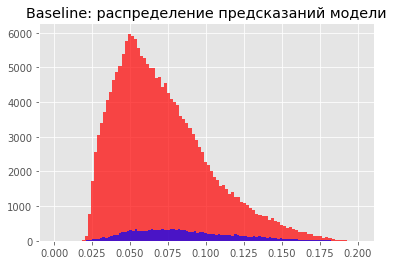

In [23]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=100, color='b', alpha=0.7);

#### Roc и PR Кривые

In [24]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc


In [25]:
fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)

Baseline: AUC_ROC = 0.626


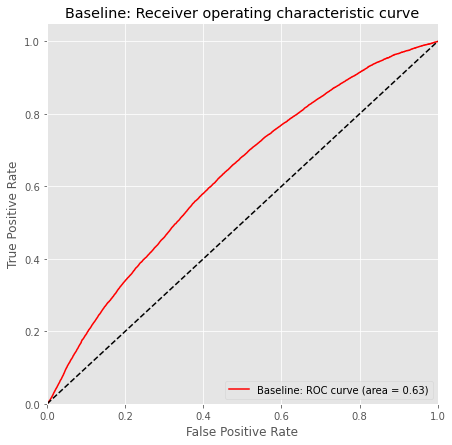

In [26]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.106


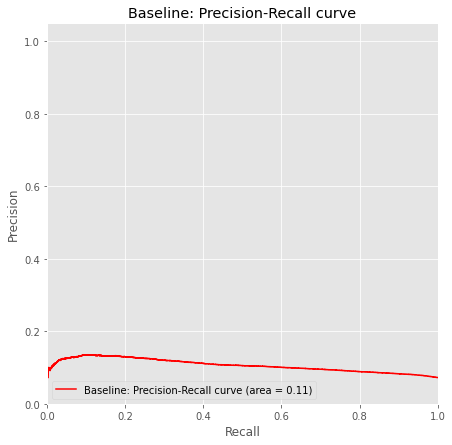

In [27]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

Максимальную точность при этом: 0.089
При каком пороге: 0.055


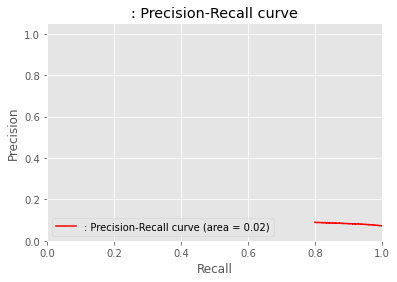

In [28]:
re80_mask = recall >= 0.8
pr_target_idx = np.arange(len(precision))[re80_mask]
pr_target = precision[re80_mask]

max_pr_idx = pr_target_idx[np.argmax(pr_target)]


print("Максимальную точность при этом: %.3f" % precision[max_pr_idx])
threshold80 = pr_thresholds[max_pr_idx]
print ("При каком пороге: %.3f" % threshold80)

plot_precision_recall_curve(recall[re80_mask], precision[re80_mask], color='r')

#### Матрица смежности

In [29]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[192854      0]
 [ 15060      0]]


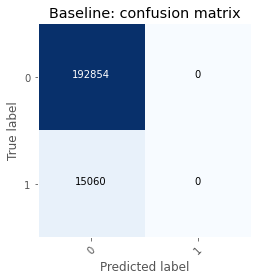

In [30]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_test, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

#### classification_report

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(y_test, bl_y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    192854
         1.0       0.00      0.00      0.00     15060

    accuracy                           0.93    207914
   macro avg       0.46      0.50      0.48    207914
weighted avg       0.86      0.93      0.89    207914



In [33]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(fp + tp)
recall = tp/(fn + tp)

accuracy = (tp + tn)/(fp + fn + tp + tn)

micro_avg_pr    = (tn + tp) / (fn + tn + fp + tp)
macro_avg_pr    = (tn/(fn + tn) + tp/(fp + tp))/2

n_0 = (y_test == 0).sum()
n_1 = (y_test == 1).sum()
weighted_avg_pr = (n_0*tn/(fn + tn) + n_1*tp/(fp + tp))/(n_0 + n_1)

print("              accuracy = %.2f"   % float(accuracy))
print("           1 precision = %.2f"   % float(precision))
print("              1 recall = %.2f"   % float(recall))
print("   micro avg precision = %.2f "  % float(micro_avg_pr))
print("   macro avg precision = %.2f "  % float(macro_avg_pr))
print("weighted avg precision = %.2f "  % float(weighted_avg_pr))

              accuracy = 0.93
           1 precision = nan
              1 recall = 0.00
   micro avg precision = 0.93 
   macro avg precision = nan 
weighted avg precision = nan 


# 2 Определение типа признаков

In [49]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [50]:
X_nunique.shape

(258,)

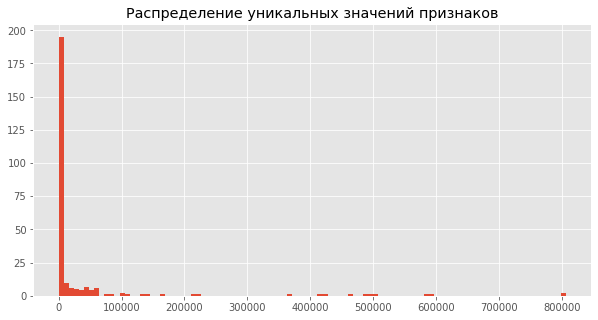

In [51]:
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(10, 5));

In [52]:
f_all = set(X_nunique.index.tolist())
len(f_all)

258

#### константные признаки

In [53]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

5

#### вещественные признаки

In [54]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

247

In [55]:
f_other = f_all - (f_numeric | f_const)
len(f_other)

6

#### бинарные

In [56]:
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

0

In [57]:
f_other = f_other - f_binary
len(f_other)

6

#### категориальные

In [58]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_numeric_extra = f_categorical

In [59]:
f_other = f_other - f_categorical
len(f_other)

5

In [60]:
f_numeric = f_numeric | f_other

In [61]:
f_other = f_other - f_numeric
len(f_other)

0

In [62]:
assert(X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

In [63]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 258

f_const: 5
f_binary: 0
f_categorical: 1
f_numeric: 252


# 3 sklearn.Pipeline

Pipeline-ы выполняют последовательность transformer-ов и могут завершаться финальным estimator-ом. Все объектов transformer-ы должны иметь два метода - fit и transform. Финальный Estimator должын иметь метод fit.

### 3.1 Column Selector

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

In [65]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [66]:
cs_pipe = Pipeline([
    ('cs', ColumnSelector(columns=f_all)),
])

In [67]:
#cs_pipe.fit(X_train)

cs_pipe.transform(X_test).head()

,213,104,222,161,75,18,194,229,45,122,188,204,65,223,231,221,38,98,id_other,135,171,95,13,182,192,33,118,249,67,106,62,16,197,31,14,155,126,105,195,56,...,30,111,200,51,166,212,201,214,84,156,109,180,170,243,112,240,55,27,137,72,81,148,168,93,184,79,23,185,0,60,179,103,245,11,124,70,198,97,206,7
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
581882,-42051.166127,-1.917583,-5.726695e+08,-0.002595,0.0,-5.41746,-0.623737,-193.128986,76.690506,-0.024048,-18.237036,0.039208,-0.028454,-58.544078,-0.364694,-0.107878,-1609.243104,-0.828382,2922806,-1.143223,-3.614497,-0.000115,-66.189127,-2.793637,-0.466683,-0.00003,-0.343415,-0.694428,-0.301128,-0.258469,0.058356,-0.016435,-0.000567,-0.001884,-68.36811,-0.000379,-0.048077,-0.040043,-0.228106,-0.671324,...,-0.211608,-0.62084,-0.02921,12.911014,81.890234,-0.243136,-0.104665,-9239.707081,-0.134088,-2.548856,-1.019293,-0.00189,71.604424,-970.373846,140.179877,271.562669,-7.745251,-0.00909,-0.825973,-2.60662,0.0,0.012836,89.765174,-0.185299,-5.008096,-0.998268,-0.001733,82.021879,-86.119971,0.674766,-0.001431,-2.29064,-25.996269,-4.007526,-119.674411,-0.130031,-0.433736,-0.348913,-0.008999,-65.076097
354454,-38643.166127,6.722417,-5.726695e+08,-0.002595,0.0,-5.41746,-0.623737,-266.128986,-62.342828,-0.024048,-35.303704,-0.960792,-0.028454,-58.544078,-0.364694,-0.107878,-2256.137674,-0.828382,1764703,0.856777,-8.614497,-0.000115,-66.189127,-2.793637,-0.466683,-0.00003,-0.343415,-0.694428,-0.301128,-9.408469,-0.091644,-0.016435,-0.000567,-0.001884,-77.51811,-0.000379,-0.058077,-0.040043,-0.228106,-1.671324,...,-0.211608,-4.62084,-0.02921,-41.088986,-44.376426,0.756864,-0.104665,-9239.707081,-0.134088,-2.548856,-1.019293,-0.00189,-42.895570,-977.373846,-1187.898245,-512.437331,-3.745251,-0.00909,1.174027,-2.60662,0.0,-0.317164,-51.984826,-0.185299,-5.008096,-0.998268,-0.001733,-26.978121,-86.629971,-0.265234,-0.001431,-2.29064,-25.996269,-4.007526,-119.674411,-0.130031,-0.433736,-0.348913,-0.008999,-65.076097
366075,-42051.166127,-3.447583,9.722381e+08,-0.002595,0.0,-5.41746,0.376263,-266.128986,120.007176,-0.024048,149.546296,0.039208,-0.028454,-52.354078,-0.364694,-0.107878,-2903.321264,-0.828382,1823193,-1.143223,12.385503,-0.000115,-22.859127,-2.793637,0.533317,-0.00003,-0.343415,-0.694428,1.698872,-9.408469,0.068356,-0.016435,-0.000567,-0.001884,-34.18811,-0.000379,-0.058077,-0.040043,0.771894,-1.671324,...,-0.211608,7.37916,-0.02921,-9.088986,80.340244,-0.243136,-0.104665,-9239.707081,-0.134088,-2.548856,-1.019293,-0.00189,70.054434,-977.373846,-1187.961723,-512.437331,-7.745251,-0.00909,-0.825973,-2.60662,0.0,-0.317164,133.081844,-0.185299,-5.008096,-0.998268,-0.001733,22.021879,-53.469971,0.544766,-0.001431,-2.29064,-25.996269,-4.007526,-119.674411,1.869969,0.566264,-0.348913,-0.008999,-65.076097
323931,-42051.166127,1.632417,9.734477e+08,-0.002595,0.0,-5.41746,0.376263,-266.128986,46.107170,-0.024048,-4.603701,0.039208,-0.028454,-48.704078,-0.364694,-0.107878,-2942.440404,-0.828382,1611507,-1.143223,4.385503,-0.000115,2.690873,-2.793637,0.533317,-0.00003,-0.343415,-0.694428,-0.301128,130.431531,0.108356,-0.016435,-0.000567,-0.001884,131.20189,-0.000379,-0.058077,-0.040043,-0.228106,5.328676,...,-0.211608,-1.62084,-0.02921,125.911014,36.173574,-0.243136,-0.104665,-9239.707081,-0.134088,-2.548856,-1.019293,-0.00189,25.887764,-977.373846,-1187.961723,-512.437331,18.254749,-0.00909,-0.825973,-2.60662,0.0,-0.007164,59.181838,-0.185299,-5.008096,-0.998268,-0.001733,24.021879,111.920029,0.494766,-0.001431,-2.29064,-25.996269,-4.007526,-119.674411,-0.130031,0.566264,-0.348913,-0.008999,-65.076097
625250,-42051.166127,-3.447583,-5.726695e+08,-0.002595,0.0,-5.41746,-0.623737,-33.128986,-33.142826,-0.024048,-17.053704,0.039208,-0.028454,-58.544078,-0.364694,-0.107878,10012.118596,-0.828382,3146094,-1.143223,12.385503,-0.000115,-66.189127,-2.793637,-0.466683,-0.00003,-0.343415,-0.694428,-0.301128,-9.408469,0.078356,-0.016435,-0.000567,-0.001884,-77.5

### 3.2 Пайплайн обработки признаков

In [68]:
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [69]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [70]:
f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['213', '104', '222', '161', '18', '194', '45', '122',
                          '188', '204', '65', '223', '231', '221', '38', '98',
                          '171', '135', '182', '95', '13', '192', 'id_other',
                          '33', '118', '249', '67', '106', '62', '16', ...])),
 ('featureunion', FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['213',
                                                                           '104',
                                                                           '222',
                                                                           '161',
                                                                           '18',
                                                                           '194',
                                  

In [71]:
X_test.shape[1]

258

In [72]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

260

### 3.3 Gridsearch для пайплайнов

In [61]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [64]:
from sklearn.model_selection import GridSearchCV

In [65]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

Про поиск имен параметров

In [ ]:
[k for k in lg_pipe.get_params().keys() if 'imputer' in k]

In [ ]:
param_grid = {
    "pipeline__featureunion__categorical_features__simpleimputer__strategy": ['most_frequent', 'constant'],
    "pipeline__featureunion__categorical_features__simpleimputer__fill_value": [-1],
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Сравним с baseline моделью, у которой roc_auc = 0.67 (+/- 0.02)

In [ ]:
param_grid = {
    "logisticregression__penalty": ['l1', 'l2'],
    "logisticregression__C": [0.01, 0.1, 5.0]
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

In [ ]:
lg_gsc.best_params_

### 3.4 Отбор признаков в пайплайнах

In [73]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

Атрибут estimator класса SelectFromModel должен иметь хотя бы один из атрибутов feature_importances_ или coef_ после выполнения метода fit.

In [74]:
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
)

In [75]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(207914, 260)

In [76]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

(207914, 260)

In [77]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [80]:
#param_grid = [
#    {"selectfrommodel__max_features": [None, 5, 10, 50, 100, 150], "selectfrommodel__threshold": [-np.inf]},
#    {"selectfrommodel__threshold": [1e-5]},
#]
#
#lg_fs_gsc = run_grid_search(lg_fs_pipe, X_train, y_train, param_grid, kfold_cv)

lg_fs_gsc = lg_fs_pipe

# 4 Финальная модель

In [78]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

In [79]:
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
    GradientBoostingClassifier()
)

In [62]:
[k for k in gb_fs_pipe.get_params().keys() if 'grad' in k]

['gradientboostingclassifier',
 'gradientboostingclassifier__ccp_alpha',
 'gradientboostingclassifier__criterion',
 'gradientboostingclassifier__init',
 'gradientboostingclassifier__learning_rate',
 'gradientboostingclassifier__loss',
 'gradientboostingclassifier__max_depth',
 'gradientboostingclassifier__max_features',
 'gradientboostingclassifier__max_leaf_nodes',
 'gradientboostingclassifier__min_impurity_decrease',
 'gradientboostingclassifier__min_samples_leaf',
 'gradientboostingclassifier__min_samples_split',
 'gradientboostingclassifier__min_weight_fraction_leaf',
 'gradientboostingclassifier__n_estimators',
 'gradientboostingclassifier__n_iter_no_change',
 'gradientboostingclassifier__random_state',
 'gradientboostingclassifier__subsample',
 'gradientboostingclassifier__tol',
 'gradientboostingclassifier__validation_fraction',
 'gradientboostingclassifier__verbose',
 'gradientboostingclassifier__warm_start']

In [81]:
#param_grid = {
#    "selectfrommodel__threshold": [-np.inf, 1e-05],
#    
#    "gradientboostingclassifier__max_depth": [1, 5],
#    "gradientboostingclassifier__n_estimators": [10, 100]
#}
#
#gb_fs_gsc = run_grid_search(gb_fs_pipe, X_train, y_train, param_grid, kfold_cv)

gb_fs_gsc = gb_fs_pipe

### 4.1 Сравнение моделей

In [84]:
#lg_fs_pipe_final = lg_fs_gsc.best_estimator_
lg_fs_pipe_final = lg_fs_gsc

lg_fs_pipe_final.fit(X_train, y_train)

lg_fs_pred = lg_fs_pipe_final.predict_proba(X_test)[:,1]

In [85]:
print(classification_report(y_test, lg_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    192854
         1.0       0.46      0.10      0.16     15060

    accuracy                           0.93    207914
   macro avg       0.70      0.54      0.56    207914
weighted avg       0.90      0.93      0.90    207914



In [87]:
#gb_fs_pipe_final = gb_fs_gsc.best_estimator_
gb_fs_pipe_final = gb_fs_gsc

gb_fs_pipe_final.fit(X_train, y_train)

gb_fs_pred = gb_fs_pipe_final.predict_proba(X_test)[:,1]

In [88]:
print(classification_report(y_test, gb_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    192854
         1.0       0.69      0.28      0.39     15060

    accuracy                           0.94    207914
   macro avg       0.82      0.63      0.68    207914
weighted avg       0.93      0.94      0.93    207914



Baseline: AUC_PR = 0.106
Baseline: AUC_ROC = 0.626
lg_fs_pred: AUC_PR = 0.373
lg_fs_pred: AUC_ROC = 0.871
gb_fs_pred: AUC_PR = 0.573
gb_fs_pred: AUC_ROC = 0.931


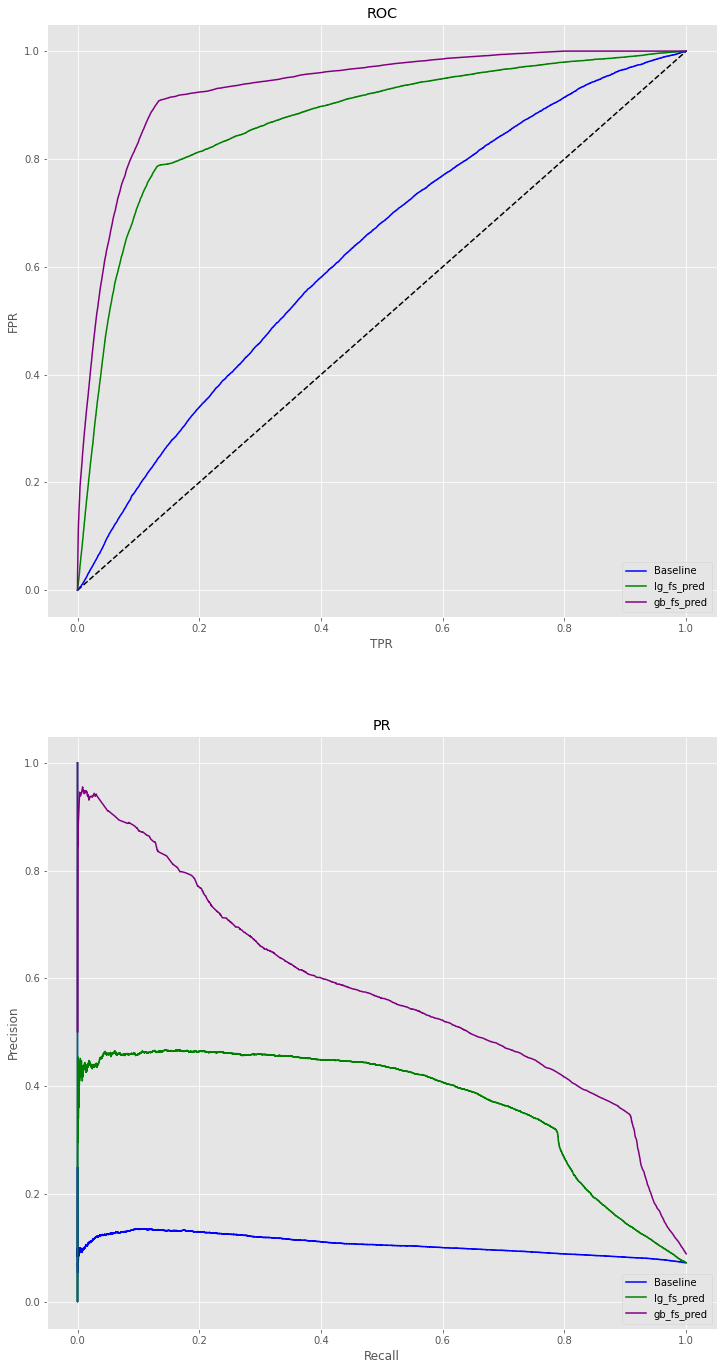

In [89]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, lg_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lg_fs_pred)
ax1.plot(fpr, tpr, label="lg_fs_pred", color='g')
ax2.plot(recall, precision, label="lg_fs_pred", color='g')
print("lg_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("lg_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, gb_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, gb_fs_pred)
ax1.plot(fpr, tpr, label="gb_fs_pred", color='purple')
ax2.plot(recall, precision, label="gb_fs_pred", color='purple')
print("gb_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("gb_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");

In [90]:
import pickle
pickle.dump(gb_fs_pipe_final, open('/content/drive/MyDrive/model.sav', 'wb'))